### What is Generalized Estimating Equations (GEE) and when should we use it?

GEE is best suited when the observations within a dataset are not independent, such as in repeated measures or nested design, and the research focus is to make population-averaged estimates. It is an alternative to linear mixed effect model (LMM), and has the following uniqueness compares to LMEM:

**1** GEE can handel a variety of distributional assumptions through the choice of a suitable link function (e.g. logit, probit, and identity), so you can use it when the outcome variable (dependent variable) is categorical or not normally distributed.  LMM only can handle continous variable and assumes a normal distribution.

**2** GEE provides population-averaged estimates (marginal estimates), which can provide information about the average effect of predictors on the population as a whole, irrespective of individual-specific variations.  This is particularly useful when the primary interest is understanidng the mean trends or making inferences about the average response across the entire population.  LMM explicitly models the subject-specific variations using randon effects.

**3** GEE is relatively robust in handling missing data. If a subject has missing observations at certain time points, both GEE and LMM can still include that subject in the analysis using the observed data points. However, GEE is less sensitive to missing observations because it focuses on population-averaged effects.

I will use the same example I've shown previously with linear mixed effect model.

In this demo, we have two groups (Disease vs. Control), and we measured their FIB-4 score at baseline (prior to treatment), 6 months after treatment, and 12 months after treatment. We hypothesized that the trend of FIB-4 score over time will be different between the two groups (i.e. we expect an interaction between study group and timepoints). In addition, the FIB-4 score in numerical value will also be converted to 3 fibrosis risk strata (low, intermediate, high), and I will run two GEE models with numerical outcome and categorical outcome respectively.


In [19]:
import pandas as pd
import random
import numpy as np

# Set a seed for reproducibility
random.seed(108)

# Generating random data
study_ids = [f'STUDY_{i}' for i in range(1, 101)]
data = []

for study_id in study_ids:
    group = random.choice(['CONTROL', 'DISEASE'])
    age = random.randint(18, 65)
    sex = random.choice(['FEMALE', 'MALE'])
    
    for time_block in ['BASELINE', 'POST_6M', 'POST_12M']:
        fib4 = round(random.uniform(0, 5), 2)
        data.append([study_id, group, age, sex, time_block, fib4])

# Creating DataFrame
df = pd.DataFrame(data, columns=['STUDY_ID', 'GROUP', 'AGE', 'SEX', 'TIME_BLOCK', 'FIB4'])

# Define the categorization function (since GEE requires numbers, so I need to convert categories to dummies 1, 2, 3)
def categorize_fib4(value):
    if np.isnan(value):
        return np.nan
    elif value < 1.45:
        return 1
    elif 1.45 <= value <= 3.25:
        return 2
    else:
        return 3

# Apply the categorization function to create the new column 'FIB4_category'
df['FIB4_category'] = df['FIB4'].apply(categorize_fib4)


# Define a mapping from timepoints in category to numeric values
timepoint_mapping = {
    'BASELINE': 0,
    'POST_6M': 1,
    'POST_12M': 2
}

# Use the replace method to convert timepoints to numeric values
df['TIMEPOINT'] = df['TIME_BLOCK'].replace(timepoint_mapping)

# sort by MRN and Timepoint, then reset index to start sequentially with 0
df = df.sort_values(by=['STUDY_ID', 'TIMEPOINT']).reset_index(drop=True)

# Display the DataFrame with the new column
print(df.head())

   STUDY_ID    GROUP  AGE     SEX TIME_BLOCK  FIB4  FIB4_category  TIMEPOINT
0   STUDY_1  CONTROL   63  FEMALE   BASELINE  4.40              3          0
1   STUDY_1  CONTROL   63  FEMALE    POST_6M  1.93              2          1
2   STUDY_1  CONTROL   63  FEMALE   POST_12M  1.38              1          2
3  STUDY_10  CONTROL   21  FEMALE   BASELINE  4.46              3          0
4  STUDY_10  CONTROL   21  FEMALE    POST_6M  0.68              1          1


### Violin graph showing each FIB4 Category (low, medium, high) distribution at different timepoints

Violin plots are especially useful when you want to compare the distribution of a variable across different categories. 

How to visualize a violin plot: higher height means higher density along the vertical axis, and wider width means higher density or concentration along the horizontal axis. 

As an example, at baseline (TIMEPOINT=0), most of the subjects in the control group fall within the "high" category, followed by "medium", then finally "low" category.  For disease group, most of the subjects fall within the "medium" and "high" categories, and a very noticable fewer subjects are in the "low" categroy.  When comparing post-6m (TIMEPOINT=1) to baseline (TIMEPOINT=0), you can see the change of category over time for the two groups.  In control group, the number of subjects in the low category decrease from baseline to post-6m. On the contrary, the number of subjects in the low category increase from baseline to post-6m for the disease group.

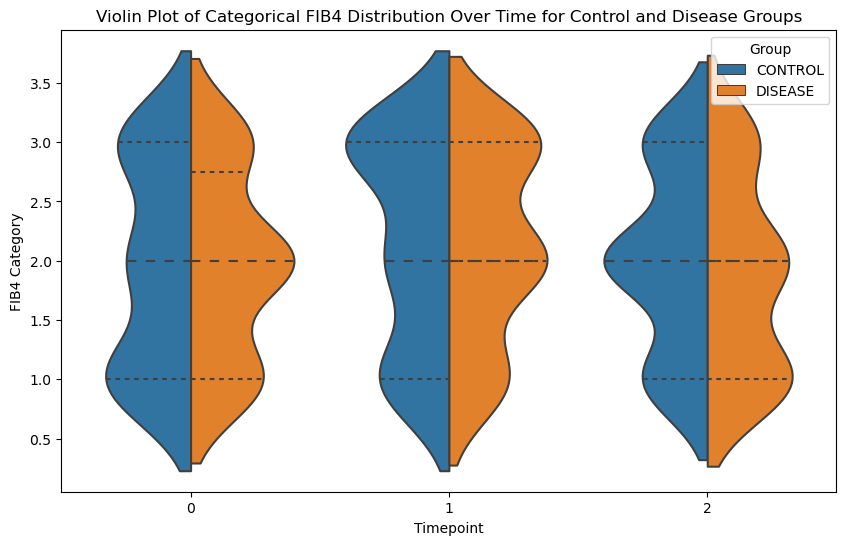

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='TIMEPOINT', y='FIB4_category', hue='GROUP', data=df, split=True, inner='quart')
plt.title('Violin Plot of Categorical FIB4 Distribution Over Time for Control and Disease Groups')
plt.xlabel('Timepoint')
plt.ylabel('FIB4 Category')
plt.legend(title='Group', loc='upper right', bbox_to_anchor=(1, 1))
plt.savefig('Group_by_Timepoint_violin_graph.png')
plt.show()


## GEE Model Specification (with numerical outcome): 

**1.** "group" typically refers to the entities or subjects for which you have repeated observations.

**2.** covariance structure aims to capture the correlation structure among measurements within these groups.  Choices are: cov_struct.Autoregressive(), cov_struct.Exchangeable(), cov_struct.Independence()

**3.** you can choose the family (i.e. the type of probability distribution assumed for the response variable) and the corresponding link function for that family. For example: Binomial family with logit as link, Gaussian family with Identity as link, Poisson family with log as link.

I chose Autoregressive as correlation structure because I think the FIB-4 scores at each timepoint are likely dependent, and that closer the timepoints, greater the dependence (e.g. T.2 is more associated with T.1 than with T.0)

I chose Gaussian as the family because my outcome here is a continous variable in normal distribution.

In [21]:
import statsmodels.api as sm
import statsmodels.genmod.cov_struct as cov_struct
import statsmodels.genmod.families as families

gee_formula = "FIB4 ~ GROUP * TIMEPOINT + SEX + AGE"
gee_model = sm.GEE.from_formula(gee_formula, groups=df['STUDY_ID'],
                            data=df, family=sm.families.Gaussian(),
                            cov_struct=cov_struct.Autoregressive(grid=True))

# Fit the GEE model
gee_results = gee_model.fit()

# Print the summary of the GEE model
print(gee_results.summary())


                               GEE Regression Results                              
Dep. Variable:                        FIB4   No. Observations:                  300
Model:                                 GEE   No. clusters:                      100
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                   3
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:       Autoregressive   Num. iterations:                     6
Date:                     Sat, 20 Jan 2024   Scale:                           2.060
Covariance type:                    robust   Time:                         13:31:11
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      2.6539      0.335      

## GEE Model Specification (with ordinal outcome):

We will use OrdinalGEE in statsmodels, the dependent variable should be a numerical representation of the ordinal categories, typically coded as integers (hence, FIB_category is now coded as dummies 1, 2, 3). 

 `cov_type` must be one of robust, naive, bias_reduced

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

gor = sm.cov_struct.GlobalOddsRatio("ordinal")

gee_formula = "FIB4_category ~ GROUP * TIMEPOINT + SEX + AGE"
gee_ordinal_model = smf.ordinal_gee(gee_formula, groups=df['STUDY_ID'], data=df, cov_struct=gor)

# Fit the GEE model
gee_ordinal_result = gee_ordinal_model.fit(maxiter=100, ctol=1e-06, start_params=None, params_niter=1, first_dep_update=0, cov_type='robust')

# Print the summary of the GEE model
print(gee_ordinal_result.summary())


                           OrdinalGEE Regression Results                           
Dep. Variable:                           y   No. Observations:                  600
Model:                          OrdinalGEE   No. clusters:                      100
Method:                        Generalized   Min. cluster size:                   6
                      Estimating Equations   Max. cluster size:                   6
Family:                           Binomial   Mean cluster size:                 6.0
Dependence structure:      GlobalOddsRatio   Num. iterations:                     7
Date:                     Sat, 20 Jan 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         13:31:12
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
I(y>1.0)                      -0.4368        nan      

C:\Users\Y432164\AppData\Local\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1838: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


## We will convert the coef in log-odds to odds ratio

Since Binomial family was used in the OrdinalGEE model, the coefficients are in the log-odds scale.  Hence, by converting it to odds ratio, it can be more easily interpreted.


In [23]:
# Create a dictionary to store odds ratios
odds_ratios = {}

# Loop through the model results and calculate odds ratios
for param, coef in gee_ordinal_result.params.items():
    # Skip the intercept terms
    if 'Intercept' in param:
        continue

    # Calculate odds ratio
    odds_ratio = np.exp(coef)

    # Store the odds ratio in the dictionary
    odds_ratios[param] = odds_ratio

# Print the results
for param, odds_ratio in odds_ratios.items():
    print(f"Odds Ratio for {param}: {odds_ratio:.3f}")


Odds Ratio for I(y>1.0): 0.646
Odds Ratio for I(y>2.0): 0.142
Odds Ratio for GROUP[T.DISEASE]: 1.077
Odds Ratio for SEX[T.MALE]: 1.143
Odds Ratio for TIMEPOINT: 1.061
Odds Ratio for GROUP[T.DISEASE]:TIMEPOINT: 0.832
Odds Ratio for AGE: 0.995


- THE END --
